In [1]:
from flickplay.get_connections import get_pymysql_con
import pandas as pd

conp = get_pymysql_con()
query = """
SELECT 
	month,
	count(distinct($user_id)) as MAU
FROM
        ( select * from fpa.derived2 where anon_user=0) x
GROUP BY
        month
ORDER BY
        month ASC"""

print('\nFetching MAU.')
print(query)
mdd = pd.read_sql(query, conp)

mdd


Fetching MAU.

SELECT 
	month,
	count(distinct($user_id)) as MAU
FROM
        ( select * from fpa.derived2 where anon_user=0) x
GROUP BY
        month
ORDER BY
        month ASC


,month,MAU
0,2,1215
1,3,1999
2,4,1240
3,5,1047
4,6,1171
5,7,934
6,8,641
7,9,604
8,10,500
9,11,525



# Models:
1. Preict engagmenet based on user attributes and events.

$f:  \{users\} \longrightarrow engagement$

$f(X(user)) = y$

2. Cluster users
- Classify users
- 
$f: \{users\} \longrightarrow \{user class\}$

3. Predict utilization of (engagement with) nft collection based on nftcollection attributes.
$f: \{nftcollection\} \longrightarrow engagement$


# Model Features
Need to determine useful features to feed into models.


### User Engagement Metrics
frequency and depth of use
* screen time
* app features utilized
    - video watch
    - comment
    - video create
* use frequency
* retention
* behaviors


X(mongo):
### User Properties
* web3 or not
    - verified nft or not
* notifications enabled
* ownership
    - how many verified nfts, which ones ( experiences.certified: bool )
    - how many experiences
* device model
    - device's performance w.r.t. feature
    - device characteristics (AR performance: double, supported: bool)


    
X(events)
### User Behviors
* video created
* how acquired
    - apple
    - regular
    - wallet connect

* whether in discord: discord dataset
    - wallet_connect, wallet addr in discord data?
    - discord roles: device fingerprinting
        > device model / OS (android vs ios)

* map use / interaction
* what user did (events) \[before web3 (clustering?)\]
1.  use of social feed
2.  using camera
3.  event: feature_session__start, prop: feature_session_type
4.  create/publish video
    - whether checked social graph event: collectible_value__social, prop: experience_id, experience_name, is_nft, ...
5.  whether hit discover page -> event: feature_session__start, prop: feature_session_type OR event: 
6.  engagement from others induced by created comment
    - likes
    - views
    - comments
    - followers
7.  notificationEnabled, wallet connected, ... permissivity other
8.  unlocked experiences [0,0,0,1,0,0,1,0,1,1,0 ...]  
    - free vs restricted (experiences.restricted: bool)
    - unlockedexperiences.type 
    - find out more 
9.  whether bought / earned something (ownership of an experience)
    - purchased with tokens / event: ?
    - ~~gotten with blue coin~~
10. chameleon game
    - event: homefeed__chamelion
11. anonymous users (need tester compile flag?)
    - loss of collectible


# NFT collections
* Need NFT collection properties from team
* 
* 
* 
* 
<!-- 
# User Clustering
* cluster by event space
* set up debug mode for event generation -->

In [4]:
web3_q = """
SELECT *from fpa.derived2 where anon_user=0 and event='profile_wallet__connect_suc';
"""
w3_users = pd.read_sql(web3_q, conp)
w3_users = set(w3_users['$user_id'])
print(len(w3_users))


w3_users = pd.read_sql(web3_q, conp)
w3_users = set(w3_users['$user_id'])
print(len(w3_users))

782


In [7]:
from flickplay.get_connections import get_pymysql_con
import pandas as pd

conp = get_pymysql_con()

cohort_maus = pd.DataFrame(columns=['month','mau','w3_mau'])
months=[]
maus=[]
w3maus=[]

for month in range(2,13):
    print(month)
    months.append(month)
    query = f"""
    SELECT month, $user_id
    FROM fpa.derived2 
    WHERE month={month} and anon_user=0
    """
    uservec = pd.read_sql(query, conp)['$user_id']
    mau=len(set(uservec))
    maus.append(mau)
    w3_mau=len(set(uservec).intersection(w3_users))
    w3maus.append(w3_mau)
    
cohort_maus['month'] = months
cohort_maus['mau'] = maus
cohort_maus['web3_mau'] = w3maus
cohort_maus=cohort_maus.drop(columns='w3_mau')
cohort_maus

2
3
4
5
6
7
8
9
10
11
12


,month,mau,w3_mau,web3_mau
0,2,1216,NaN,30
1,3,2000,NaN,55
2,4,1241,NaN,93
3,5,1047,NaN,131
4,6,1171,NaN,200
5,7,934,NaN,349
6,8,641,NaN,207
7,9,604,NaN,252
8,10,500,NaN,224
9,11,525,NaN,244


In [37]:
c=cohort_maus.reset_index(drop=True)
c.index=c['month']
c

,month,mau,web3_mau
month,,,
2,2,1216,30
3,3,2000,55
4,4,1241,93
5,5,1047,131
6,6,1171,200
7,7,934,349
8,8,641,207
9,9,604,252
10,10,500,224


Text(0, 0.5, 'MAU')

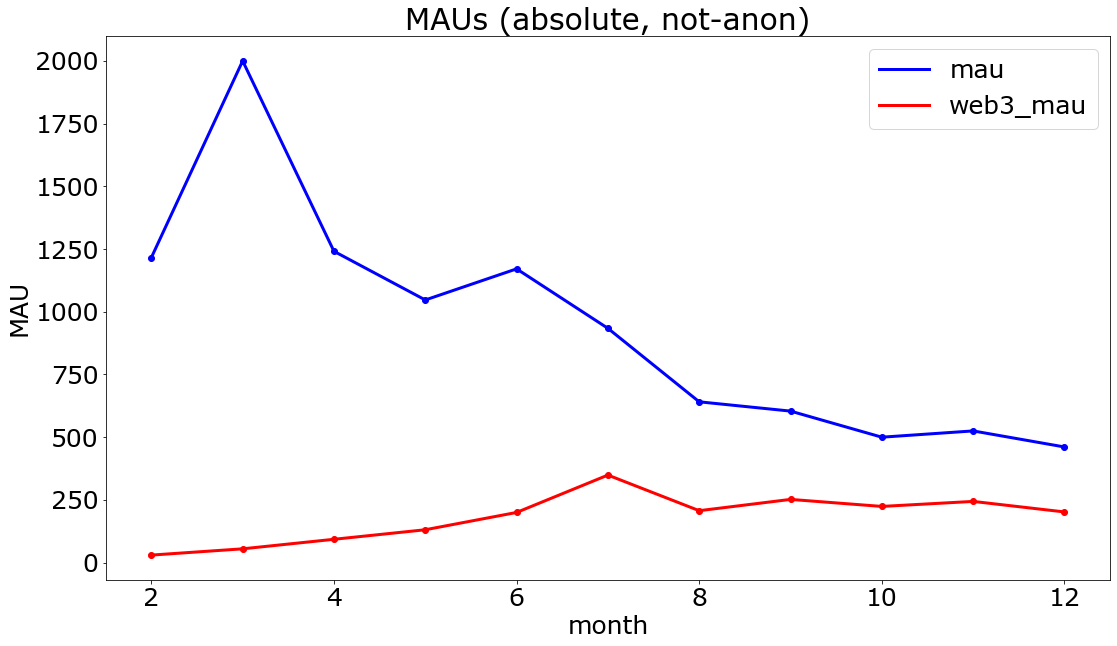

In [52]:
# cohort_maus
# # cohort_maus=cohort_maus.drop(columns='w3_mau')
# cohort_maus.index = [_+2 for _ in list(cohort_maus.index)]
c=cohort_maus.reset_index(drop=True)
lw=3

fig, ax = make_big(f=25)
c.drop(columns='month')
ax.plot(c.month, c.mau, label='mau',color='b', linewidth=lw)

ax.plot(c.month, c.web3_mau, label='web3_mau',color='r', linewidth=lw)
ax.scatter(c.month, c.web3_mau,color='r')
ax.scatter(c.month, c.mau,color='b')
plt.legend()
plt.title('MAUs (absolute, not-anon)')
plt.xlabel('month')
plt.ylabel('MAU')




# scaler, c = get_minmax_scaled(c)
# # cohort_maus_s['month'] = c['month']
# # c.drop(columns='month')
# ax.plot(c.month, c.mau, label='mau',color='b')
# ax.scatter(c.month, c.mau, label='mau',color='b')
# ax.plot(c.month, c.web3_mau, label='web3_mau',color='r')
# ax.scatter(c.month, c.web3_mau, label='web3_mau',color='r')

# plt.legend()
# plt.xlabel('month')

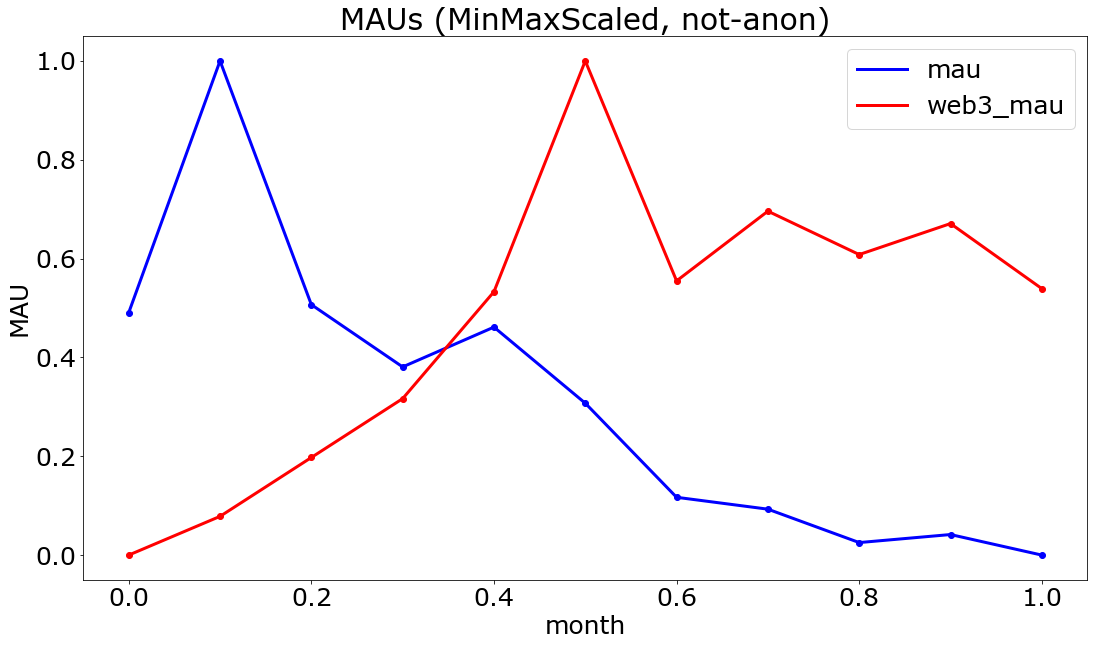

In [53]:

scaler,c = get_minmax_scaled(c)
fig, ax = make_big(f=25)
c.drop(columns='month')
ax.plot(c.month, c.mau, label='mau',color='b', linewidth=3)
ax.scatter(c.month, c.mau,color='b')
ax.plot(c.month, c.web3_mau, label='web3_mau',color='r', linewidth=3)
ax.scatter(c.month, c.web3_mau, color='r')
plt.title('MAUs (MinMaxScaled, not-anon)')
plt.xlabel('month')
plt.ylabel('MAU')
plt.legend()

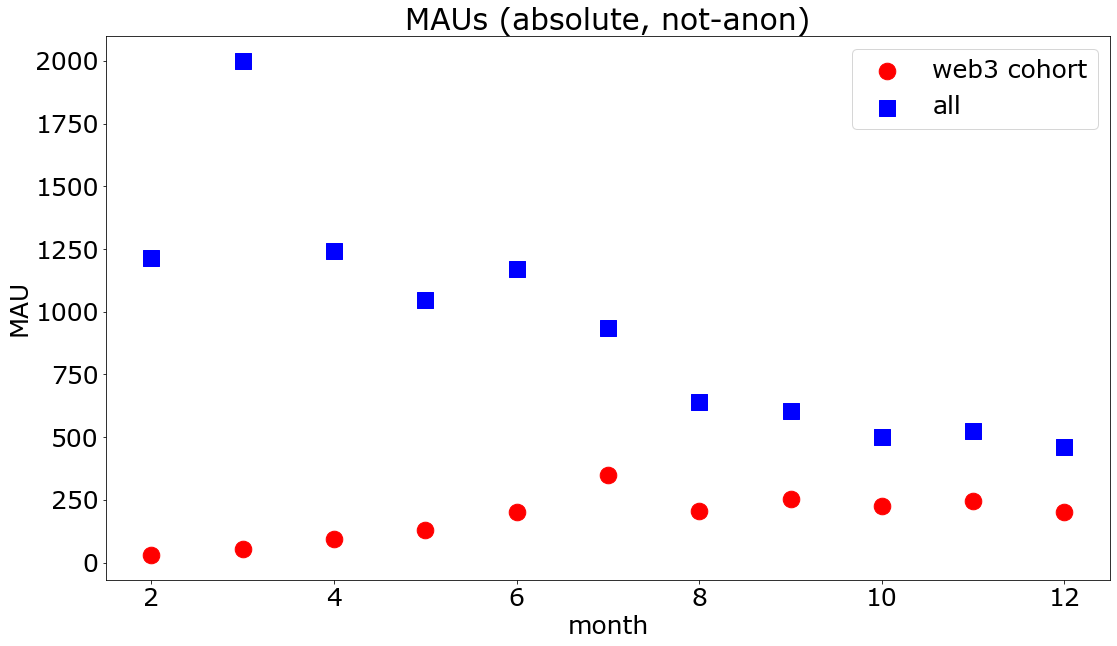

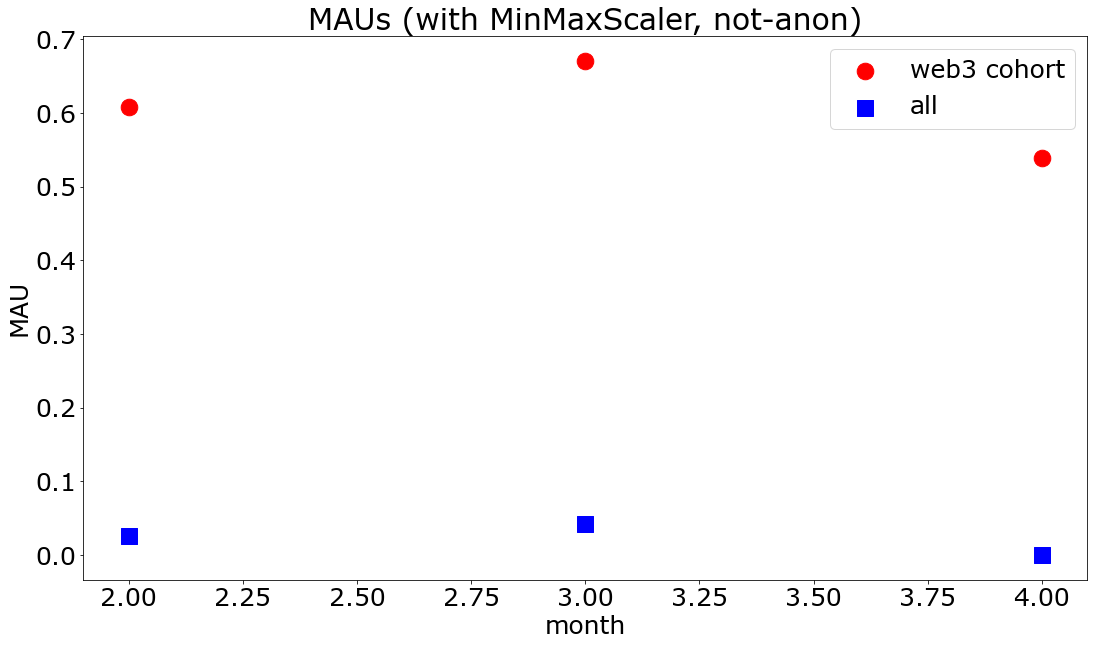

In [28]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rc

s=275

def set_fig_size(width=18,height=10):
    fig,ax=plt.subplots(1,1)
    fig.set_size_inches(width,height)
    return fig,ax
    

def set_font_size(size=18):
    font = {'family' : 'verdana',
            'size'   : size}
    rc('font', **font)
    
def make_big(f=18,w=18,h=10):
    set_font_size(size=f)
    fig, ax = set_fig_size(width=w,height=h)
    return fig, ax

def get_minmax_scaled(data:pd.DataFrame):
    data = data.copy()
    scaler = MinMaxScaler()
    return scaler, pd.DataFrame(columns = data.columns,
                 data = scaler.fit_transform(data.to_numpy()))


cohort_maus=c

fig,ax = make_big(f=25)
ax.scatter(
    cohort_maus.month, 
    cohort_maus.web3_mau, 
    label='web3 cohort', 
    color='r', 
    marker='o', 
    s=s)
ax.scatter(
    cohort_maus.month, 
    cohort_maus.mau, 
    label='all', 
    color='b', 
    marker='s', 
    s=s)
plt.title('MAUs (absolute, not-anon)')
plt.xlabel('month')
plt.ylabel('MAU')
plt.legend(loc=1)
plt.show()


scaler, cohort_maus_s = get_minmax_scaled(cohort_maus)
cohort_maus_s['month'] = c['month']

fig,ax=make_big(f=25)
plt.scatter(
    cohort_maus_s.month, 
    cohort_maus_s.web3_mau, 
    label='web3 cohort', 
    color='r', 
    marker='o', 
    s=s)
plt.scatter(
    cohort_maus_s.month, 
    cohort_maus_s.mau, 
    label='all', 
    color='b', 
    marker='s', 
    s=s)
plt.title('MAUs (with MinMaxScaler, not-anon)')
plt.xlabel('month')
plt.ylabel('MAU')
plt.legend(loc=1)
plt.show()
# plt.plot(
#     cohort_maus_s.month, 
#     cohort_maus_s.mau, 
#     label='all', 
#     color='b', 
#     marker='s', 
#     s=s)
# plt.title('MAUs (with MinMaxScaler, not-anon)')
# plt.xlabel('month')
# plt.ylabel('MAU')
# plt.legend(loc=1)
# plt.show()

,month,mau,w3_mau


In [6]:
# cols = pd.read_sql('''show columns from fpa.derived2''',conp).Field.values

# scols = [
#     'event', 
#     'date', #'time', 
#     '$user_id', #'user_gps_location',
#     'anon_user', #'wallet_address', 'month', 'day', 'week', 'dt',
#        'hour']

array(['event', 'date', 'time', '$user_id', 'user_gps_location',
       'anon_user', 'wallet_address', 'month', 'day', 'week', 'dt',
       'hour'], dtype=object)

In [16]:
# dat = """
# SELECT 
    